<a href="https://colab.research.google.com/github/rakin1234/Semantic-Segmentation-of-High-Voltage-Power-Line-Insulator-Images/blob/main/Glass_Insulator_GradCam_using_LinkNet_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gazimerazmehedi_final_gridcam_analysis_insulator_path = kagglehub.dataset_download('gazimerazmehedi/final-gridcam-analysis-insulator')
gazimerazmehedi_linknet_vgg19_porcelain_gradcam_pytorch_default_1_path = kagglehub.model_download('gazimerazmehedi/linknet-vgg19-porcelain-gradcam/PyTorch/default/1')
gazimerazmehedi_linknet_vgg19_polymer_444_pytorch_default_1_path = kagglehub.model_download('gazimerazmehedi/linknet-vgg19-polymer-444/PyTorch/default/1')
gazimerazmehedi_linknet_vgg19_glass_444_pytorch_default_1_path = kagglehub.model_download('gazimerazmehedi/linknet-vgg19-glass-444/PyTorch/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linknet-vgg19-porcelain-gradcam/pytorch/default/1/linknet_vgg19_porcelain.pth
/kaggle/input/linknet-vgg19-glass-444/pytorch/default/1/linknet_vgg19_glass.pth
/kaggle/input/linknet-vgg19-polymer-444/pytorch/default/1/linknet_vgg19_polymer.pth
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Glass/13159.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Glass/13155.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Glass/13151.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Glass/24035.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Porcelain/35003.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Porcelain/35002.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Porcelain/35011.png
/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Fi

In [ ]:
!pip install segmentation_models_pytorch grad-cam --quiet

In [ ]:
pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


# GLASS Heatmap

<ipython-input-30-819dac74c280>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Full visualization frame saved as: GridCAM_Glass_Insulator_1200DPI.jpg


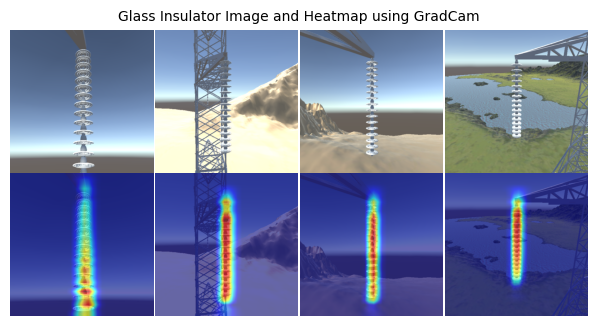

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from segmentation_models_pytorch import Linknet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from glob import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load model linknet
def load_linknet_vgg19():
    model = Linknet(encoder_name="vgg19",
                    classes=2,
                    activation=None,
                    encoder_weights=None)

    model_path = '/kaggle/input/linknet-vgg19-glass-444/pytorch/default/1/linknet_vgg19_glass.pth'
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)
    model.eval()

    #disable stochastic components
    #ensuring no neuronsrandomly dropped
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0
    return model

model = load_linknet_vgg19()

#preprocessing img
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0).to(device)

#gradCAM target class
class SegmentationTarget:
    def __init__(self, class_idx):
        self.class_idx = class_idx

    def __call__(self, model_output):
        if model_output.dim() == 4:
            return model_output[:, self.class_idx, :, :].mean()
        elif model_output.dim() == 3:
            return model_output[self.class_idx, :, :].mean()
        raise ValueError(f"Unsupported output dim: {model_output.dim()}")

#gradCAM visualization for 1 img
def generate_visualization(image_path):
    input_tensor = preprocess_image(image_path)

    #denormalize img for visualization
    denorm_img = input_tensor[0].cpu().clone()
    denorm_img_np = denorm_img.clamp(0, 1).permute(1, 2, 0).numpy()

    #gradCAM configuration
    target_layer = model.encoder.features[-3]
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [SegmentationTarget(class_idx=1)]  #change class if need

    #heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    cam_visualization = show_cam_on_image(denorm_img_np.astype(np.float32),
                                          grayscale_cam,
                                          use_rgb=True,
                                          image_weight=0.4)
    return denorm_img_np, cam_visualization
#process all imgs
image_dir = '/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Glass'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
image_files = image_files[:4]  #use 4imgs

#storing results
results = []
for image_path in image_files:
    original_img, cam_visualization = generate_visualization(image_path)
    results.append((original_img, cam_visualization))


# Row 0 = Original, Row 1= heatmaps
cols = 4
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(6, 3))
plt.subplots_adjust(wspace=0, hspace=0.4)

for idx, (original_img, cam_visualization) in enumerate(results):
    axes[0, idx].imshow(original_img)
    axes[0, idx].axis("off")

    axes[1, idx].imshow(cam_visualization)
    axes[1, idx].axis("off")

#title
fig.suptitle("Glass Insulator Image and Heatmap using GradCam", fontsize=10, y=1.02)
plt.tight_layout(pad=0)

#save pic
output_frame_path = "GridCAM_Glass_Insulator_1200DPI.jpg"
plt.savefig(output_frame_path, format='jpg', dpi=1200, bbox_inches='tight')
print(f"Full visualization frame saved as: {output_frame_path}")
plt.show()


# Predicted segmentation mask

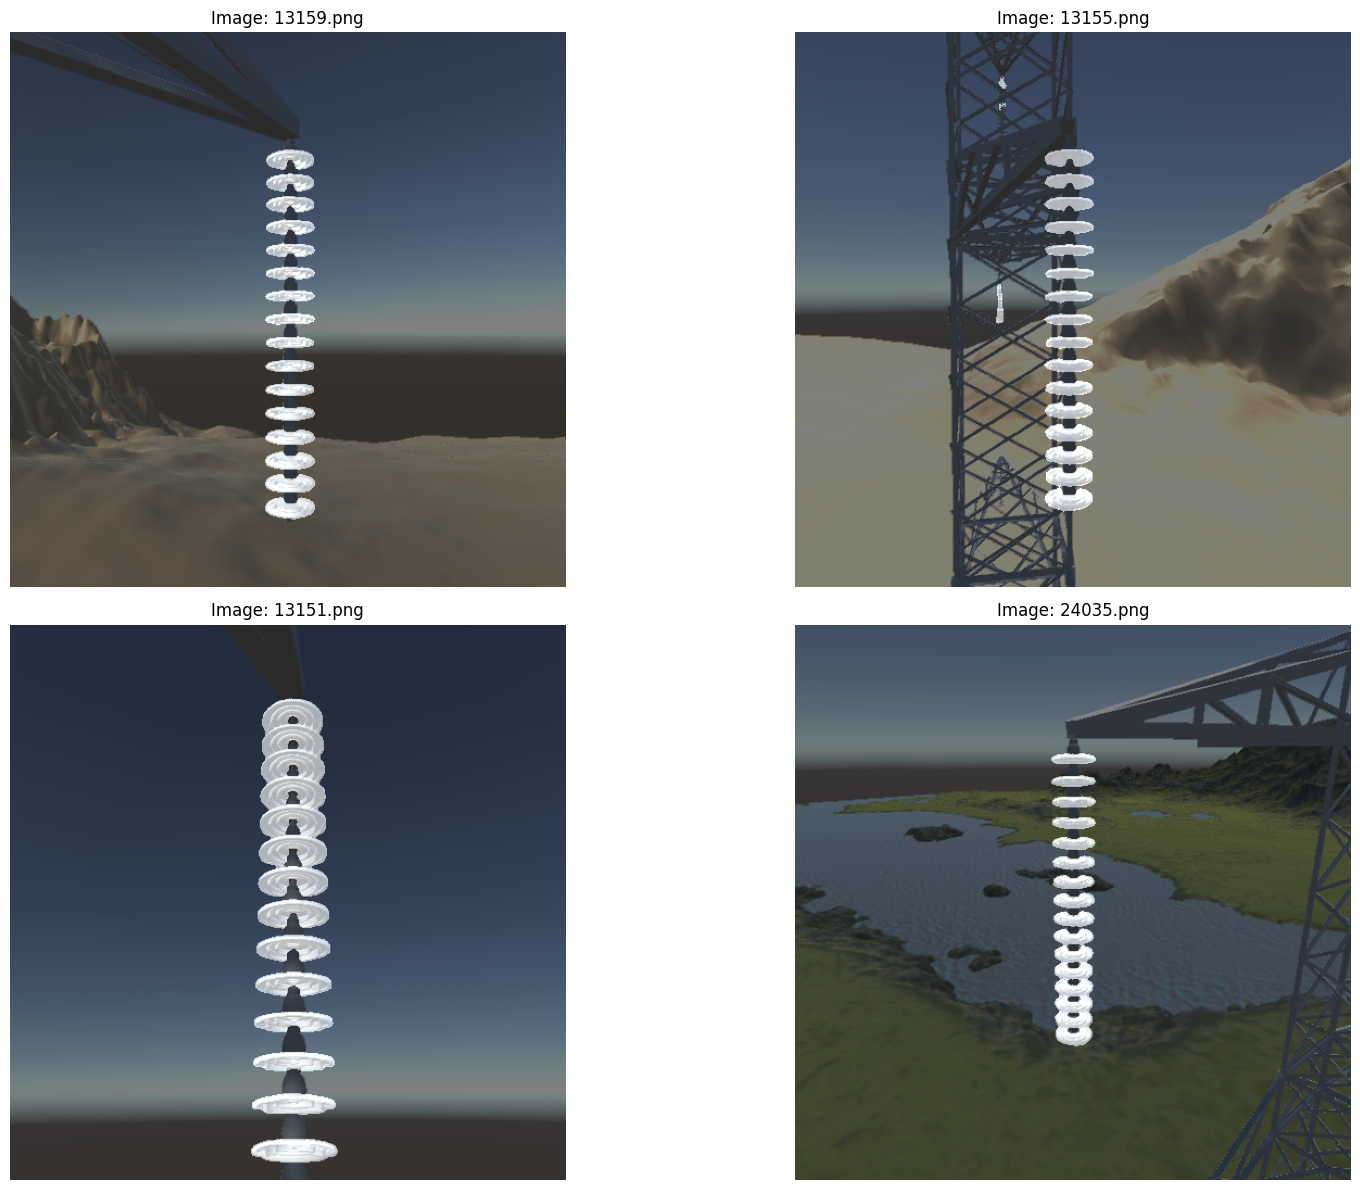

In [ ]:

image_dir = '/kaggle/input/final-gridcam-analysis-insulator/Insulator GradCam Final Dataset/Glass'
image_paths = glob(os.path.join(image_dir, '*.png'))

# Set up the plot
num_images = len(image_paths)
cols = 2
rows = (num_images + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))

#flatten axes array to easy iteratate
axes = axes.flatten()

for idx, image_path in enumerate(image_paths):
    input_tensor = preprocess_image(image_path)

    #denormalize
    denorm_img = input_tensor[0].cpu().clone()
    denorm_img_np = denorm_img.clamp(0, 1).permute(1, 2, 0).numpy()

    target_layer = model.encoder.features[-3]
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [SegmentationTarget(class_idx=1)]  # Change class if need

    #generate heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(denorm_img_np.astype(np.float32),
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.4)

    #compute predicted mask
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output)
        pred_mask = (pred_mask > 0.5).float().cpu().squeeze()

        #for binary segmentation with shape (2, H, W) =
        #select channel 0 for insulator
        pred_mask = pred_mask[0].numpy()

    #invert mask (object in white, background in black)
    pred_mask_inverted = np.invert(pred_mask.astype(bool)).astype(np.float32)

    # Visualization
    axes[idx].imshow(denorm_img_np)
    axes[idx].imshow(pred_mask_inverted, cmap='gray', alpha=0.5)
    axes[idx].set_title(f"Image: {os.path.basename(image_path)}")
    axes[idx].axis("off")

#hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
